In [280]:
import copy
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import rootpy
import scipy

import PTI.ReadDataFiles
reload(PTI.ReadDataFiles)
from PTI.ReadDataFiles import PTIData

## Determining the Baseline Subtraction

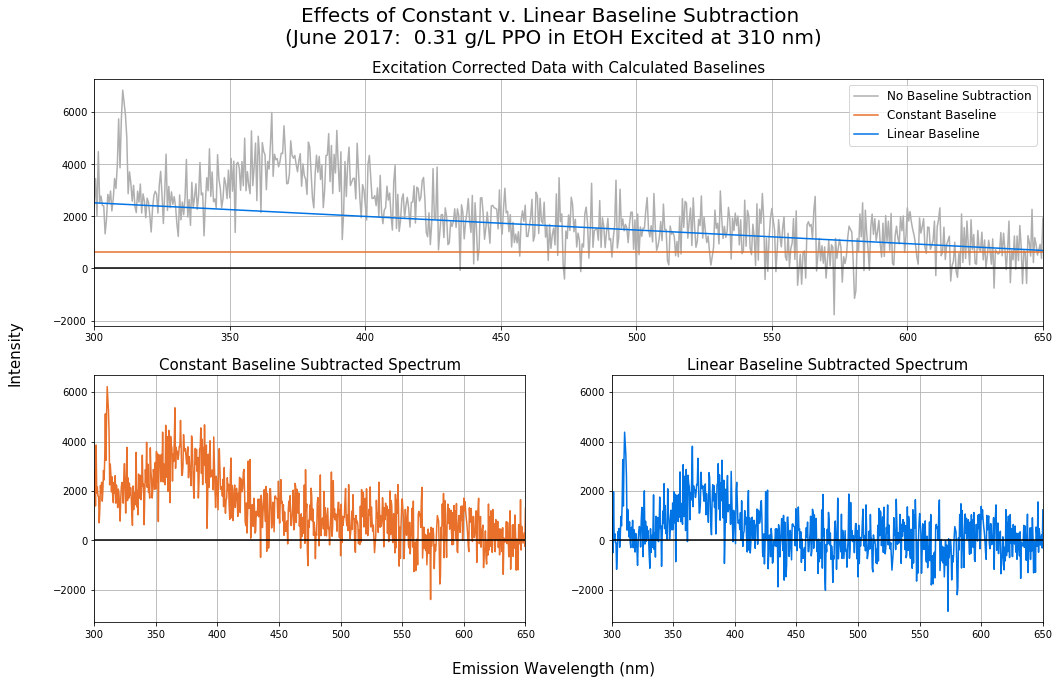

In [320]:
path = "Noah/Integrating Sphere Tests for PPO Contamination/"
test_data = PTIData(path + "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt")

raw_or_corrected = 'cor' # EXcitation correction
wavelength_ranges = [[440,650]]

fig = plt.figure(figsize=(17,10))
fig.suptitle("Effects of Constant v. Linear Baseline Subtraction \n"+
             "(June 2017:  0.31 g/L PPO in EtOH Excited at 310 nm)",fontsize=20)
fig.text(0.5, 0.06, 'Emission Wavelength (nm)', ha='center', va='center',fontsize=15)
fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical',fontsize=15)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1), sharey=ax2)

ax1.plot(test_data.wavelengths, test_data.cor_data,'#afafaf')
ax1.plot(test_data.wavelengths, test_data.get_baseline(raw_or_corrected, 'const', wavelength_ranges),'#e8702a')
ax1.plot(test_data.wavelengths, test_data.get_baseline(raw_or_corrected, 'linear', wavelength_ranges),'#0073e5')
ax1.plot(test_data.wavelengths, 0*test_data.wavelengths,'k')
ax1.set_title("Excitation Corrected Data with Calculated Baselines", fontsize=15)
ax1.legend(['No Baseline Subtraction', "Constant Baseline", "Linear Baseline"], fontsize=12)

ax2.plot(test_data.wavelengths, test_data.get_baseline_subtracted(raw_or_corrected, 'const', wavelength_ranges),'#e8702a')
ax2.plot(test_data.wavelengths, 0*test_data.wavelengths,'k')
ax2.set_xlim([test_data.wavelengths[0], test_data.wavelengths[-1]])
ax2.set_title("Constant Baseline Subtracted Spectrum", fontsize=15)

ax3.plot(test_data.wavelengths, test_data.get_baseline_subtracted(raw_or_corrected, 'linear', wavelength_ranges),'#0073e5')
ax3.plot(test_data.wavelengths, 0*test_data.wavelengths,'k')
ax3.set_xlim([test_data.wavelengths[0], test_data.wavelengths[-1]])
ax3.set_title("Linear Baseline Subtracted Spectrum", fontsize=15)

for ax in [ax1, ax2,ax3]:
    ax.set_xlim([300, 650])
    ax.grid()
    
plt.show()

**Conclusion**: The linear baseline subtraction is the most effect means of performing a baseline subtraction.

## Determining the Effect of Emission Correction

In [ ]:
'''Interpolates between two points by taking the average of them. Returns an array twice the size'''
def interpolate_with_avg(array):
    return np.append(np.dstack((array[:-1], array[:-1] + np.diff(array)/2)).ravel(), array[-1])

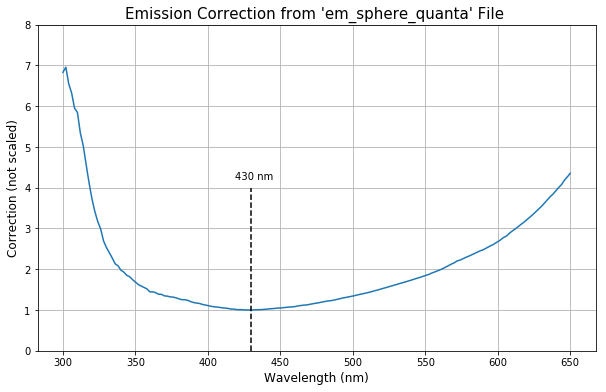

In [372]:
# Import emission correction files
emcorr_quanta_sphere_wavelengths = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                                 skip_header = 6,
                                                 usecols = 0,
                                                 max_rows = (848-300)/2 +1)
emcorr_quanta_sphere_values = np.genfromtxt("PTI/correction_data/emcorr-sphere-quanta.txt", 
                                            skip_header = 6,
                                            usecols = 1,
                                            max_rows = (848-300)/2 +1)

emcorr_quanta_sphere_wavelengths = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_wavelengths))
emcorr_quanta_sphere_values = interpolate_with_avg(interpolate_with_avg(emcorr_quanta_sphere_values))


start_wavelength = 300
end_wavelength = 650
desired_wavelengths = np.where((emcorr_quanta_sphere_wavelengths >= start_wavelength) & 
                               (emcorr_quanta_sphere_wavelengths <= end_wavelength))

emcorr_quanta_sphere_values = emcorr_quanta_sphere_values[desired_wavelengths]

figure = plt.figure(figsize=(10,6))
plt.plot(emcorr_quanta_sphere_wavelengths[desired_wavelengths],emcorr_quanta_sphere_values)
plt.title("Emission Correction from 'em_sphere_quanta' File ",fontsize=15)
plt.xlabel("Wavelength (nm)",fontsize=12)
plt.ylabel("Correction (not scaled)",fontsize=12)
plt.ylim([0,8])
plt.grid()

plt.axvline(x=430, ymax=0.5, color='k', linestyle='--')
plt.text(419, 4.2,"430 nm")

plt.show()

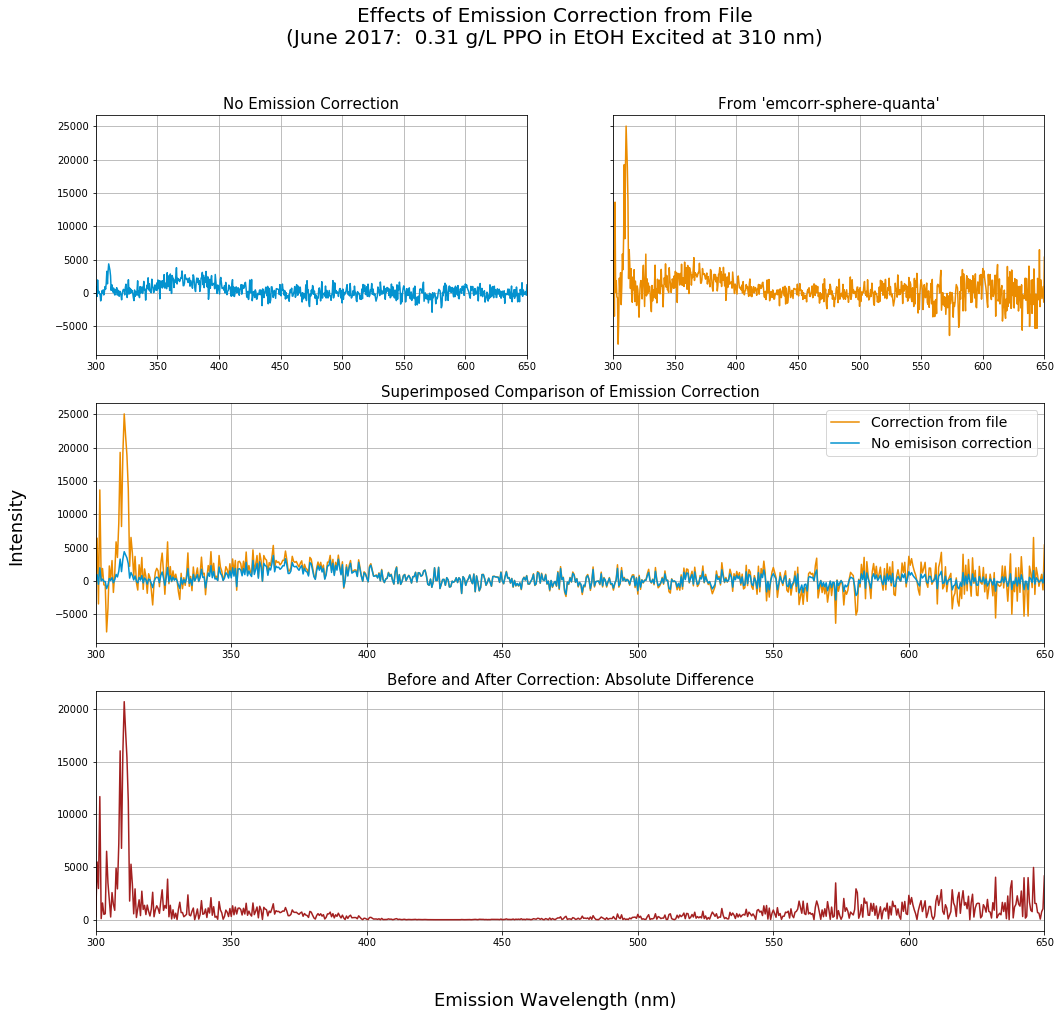

In [376]:
path = "Noah/Integrating Sphere Tests for PPO Contamination/"
test_data = PTIData(path + "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt")

raw_or_corrected = 'cor' # EXcitation correction
wavelength_ranges = [[440,650]]

no_emcor = test_data.get_baseline_subtracted(raw_or_corrected, 'linear', wavelength_ranges)
emcor = np.multiply(no_emcor,emcorr_quanta_sphere_values)


fig = plt.figure(figsize=(17,15))
fig.suptitle("Effects of Emission Correction from File\n"+
             "(June 2017:  0.31 g/L PPO in EtOH Excited at 310 nm)",fontsize=20)
fig.text(0.5, 0.06, 'Emission Wavelength (nm)', ha='center', va='center',fontsize=18)
fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical',fontsize=18)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax2 = plt.subplot2grid((3, 2), (0, 1),sharey = ax1)
ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=2,sharex=ax3)

ax1.plot(test_data.wavelengths, no_emcor, "#0392cf")
ax1.set_title("No Emission Correction", fontsize=15)

ax2.plot(test_data.wavelengths, emcor,"#eb8c00")
ax2.set_title("From 'emcorr-sphere-quanta'", fontsize=15)
plt.setp(ax2.get_yticklabels(), visible=False)

ax3.plot(test_data.wavelengths, emcor,"#eb8c00")

ax3.plot(test_data.wavelengths, no_emcor, "#0392cf")
ax3.legend(["Correction from file","No emisison correction"], fontsize=14)
ax3.set_title("Superimposed Comparison of Emission Correction", fontsize=15)

ax4.plot(test_data.wavelengths, np.abs(emcor-no_emcor), '#a32020')
ax4.set_title("\n\nBefore and After Correction: Absolute Difference", fontsize=15)

for ax in [ax1, ax2,ax3,ax4]:
    ax.grid()
    ax.set_xlim([300,650])

plt.show()

**Conclusion**: As we expect, the correction has a larger effect on shorter wavelengths and reaches a minimum at about 430 nm. After this point, however, the correction increases again. Hence, our results agree with the expected effects. 

In [450]:
def calc_QY(pti_blank_data, pti_fluor_data, 
           ex_integration_range, em_integration_range,
           ranges_for_baseline = [[450,650]],
           em_correction_array=None):

    b_data = pti_blank_data.get_baseline_subtracted('cor','linear',ranges_for_baseline)
    f_data = pti_fluor_data.get_baseline_subtracted('cor','linear',ranges_for_baseline)
    
    em_corrected_difference = np.multiply(b_data - f_data, em_correction_array)
    
    ex_limits = np.where((pti_blank_data.wavelengths >= ex_integration_range[0]) & 
                         (pti_blank_data.wavelengths <= ex_integration_range[1]))
    num_absorbed = np.trapz(y = em_corrected_difference[ex_limits],
                            x = pti_blank_data.wavelengths[ex_limits],
                            dx= pti_blank_data.step_size)
    
    em_limits = np.where((pti_blank_data.wavelengths >= em_integration_range[0]) & 
                         (pti_blank_data.wavelengths <= em_integration_range[1]))
    num_emitted = np.trapz(y = -em_corrected_difference[em_limits],
                           x = pti_blank_data.wavelengths[em_limits],
                           dx= pti_blank_data.step_size)
    
    return num_emitted/num_absorbed

In [546]:
aug_2016_prefix = "Henry/Sphere/PPO_ETOH/"
jun_2017_prefix = "Noah/Integrating Sphere Tests for PPO Contamination/"

# In order of pure EtOH, 0.31 g/L PPO, and 3.14 g/L PPO
aug_2016_data = [PTIData(aug_2016_prefix + "EmissionScan_ETOH_ex310_2sec_160830.txt"),
                 PTIData(aug_2016_prefix + "EmissionScan_0x31gperL_PPOinETOH_ex310_2sec_160831.txt"),
                 PTIData(aug_2016_prefix + "EmissionScan_3x14gperL_PPOinETOH_ex310_2sec_160831.txt")]

# In order of pure EtOH, 0.31 g/L PPO, and 3.14 g/L PPO
jun_2017_data = [PTIData(jun_2017_prefix + "EmScan_IS_0x00gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt"),
                 PTIData(jun_2017_prefix + "EmScan_IS_0x31gperL_PPOinETOH_ex310_em300-650_2sec_20170622_noemcorr.txt")]

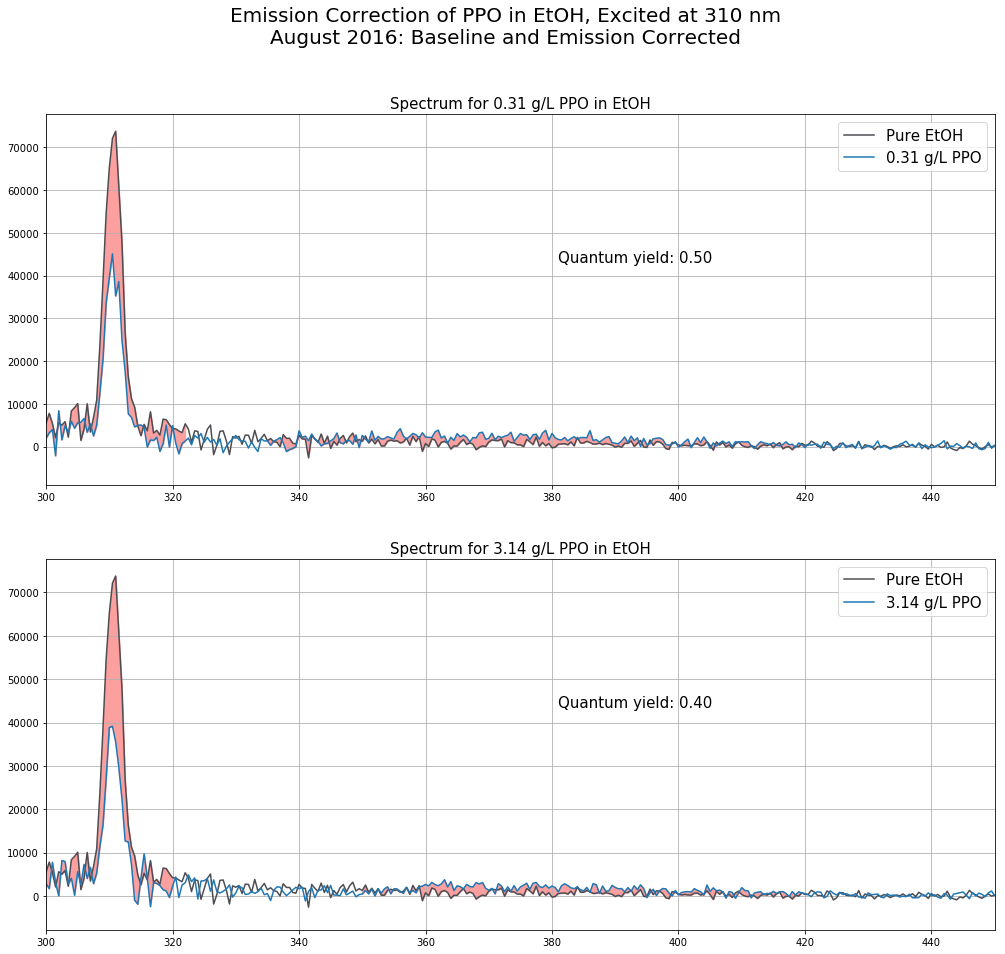

In [551]:
ranges_for_baseline = [[450,650]]


## Get the baseline and emitted subtracted intensities for plotting
aug_2016_emcorr_intensities = list() # Baseline and emission corrected
for data_set in aug_2016_data:
    baseline_corrected = data_set.get_baseline_subtracted('cor','linear',ranges_for_baseline)
    emission_corrected = np.multiply(emcorr_quanta_sphere_values, baseline_corrected)
    aug_2016_emcorr_intensities.append(emission_corrected)

## Calculate the two quantum yields

# The integration ranges
QY_0x31_ex_range = [300,322]
QY_0x31_em_range = [335,420]
QY_3x14_ex_range = [300,320]
QY_3x14_em_range = [350,420]


aug_2016_QY_0x31 = calc_QY(aug_2016_data[0], aug_2016_data[1],
                       QY_0x31_ex_range,QY_0x31_em_range,
                       ranges_for_baseline = ranges_for_baseline,
                       em_correction_array=emcorr_quanta_sphere_values)

aug_2016_QY_3x14 = calc_QY(aug_2016_data[0], aug_2016_data[2],
                       QY_3x14_ex_range,QY_3x14_em_range,
                       ranges_for_baseline = ranges_for_baseline,
                       em_correction_array=emcorr_quanta_sphere_values)


fig = plt.figure(figsize=(17,15))
plt.suptitle("Emission Correction of PPO in EtOH, Excited at 310 nm\n"+
             "August 2016: Baseline and Emission Corrected",fontsize=20)

ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0),sharex=ax1)

ax1.plot(aug_2016_data[0].wavelengths, aug_2016_emcorr_intensities[0],"#4c4d52")
ax1.plot(aug_2016_data[1].wavelengths, aug_2016_emcorr_intensities[1])
ax1.set_title("Spectrum for 0.31 g/L PPO in EtOH",fontsize=15)
ax1.legend(["Pure EtOH", "0.31 g/L PPO"],fontsize=15)
ax1.fill_between(aug_2016_data[0].wavelengths, aug_2016_emcorr_intensities[0], aug_2016_emcorr_intensities[1],
                 where = ((aug_2016_data[0].wavelengths >= QY_0x31_ex_range[0]) &
                          (aug_2016_data[0].wavelengths <= QY_0x31_ex_range[1])),
                 color =  "#fb9f9f")
ax1.fill_between(aug_2016_data[0].wavelengths, aug_2016_emcorr_intensities[0], aug_2016_emcorr_intensities[1],
                 where = ((aug_2016_data[0].wavelengths >= QY_0x31_em_range[0]) &
                          (aug_2016_data[0].wavelengths <= QY_0x31_em_range[1])),
                 color =  "#fb9f9f")
ax1.text(0.54,0.6,"Quantum yield: %.2f" %aug_2016_QY_0x31,transform=ax1.transAxes,fontsize=15)

ax2.plot(aug_2016_data[0].wavelengths, aug_2016_emcorr_intensities[0],"#4c4d52")
ax2.plot(aug_2016_data[2].wavelengths, aug_2016_emcorr_intensities[2])
ax2.set_title("Spectrum for 3.14 g/L PPO in EtOH",fontsize=15)
ax2.legend(["Pure EtOH", "3.14 g/L PPO"],fontsize=15)
ax2.fill_between(aug_2016_data[0].wavelengths, aug_2016_emcorr_intensities[0], aug_2016_emcorr_intensities[2],
                 where = ((aug_2016_data[0].wavelengths >= QY_3x14_ex_range[0]) &
                          (aug_2016_data[0].wavelengths <= QY_3x14_ex_range[1])),
                 color =  "#fb9f9f")
ax2.fill_between(aug_2016_data[0].wavelengths, aug_2016_emcorr_intensities[0], aug_2016_emcorr_intensities[2],
                 where = ((aug_2016_data[0].wavelengths >= QY_3x14_em_range[0]) &
                          (aug_2016_data[0].wavelengths <= QY_3x14_em_range[1])),
                 color =  "#fb9f9f")
ax2.text(0.54,0.6,"Quantum yield: %.2f" %aug_2016_QY_3x14,transform=ax2.transAxes,fontsize=15)


for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlim([300,450])
plt.show()

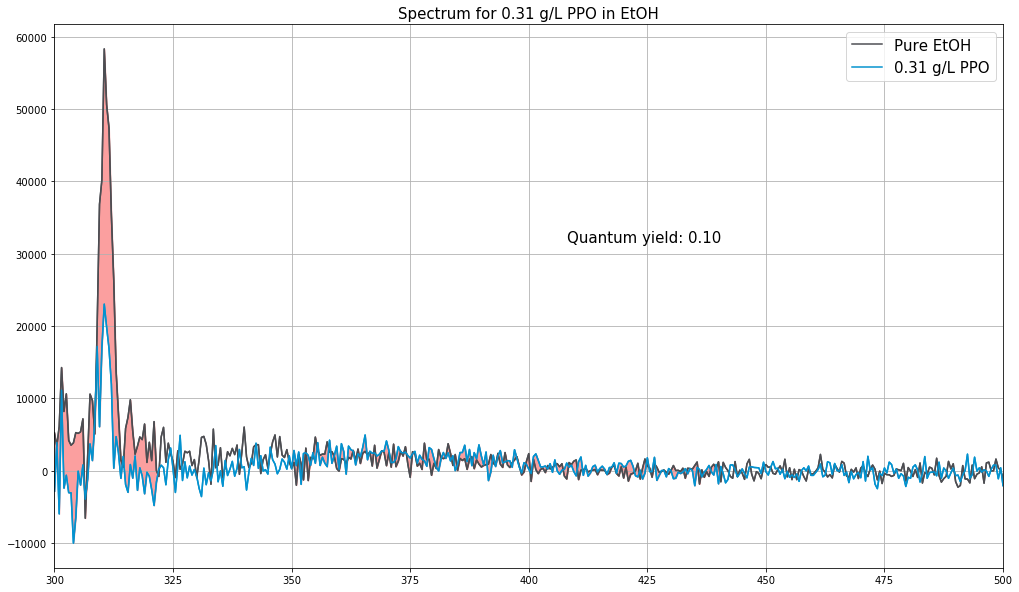

In [555]:
ranges_for_baseline = [[400,650]]

jun_2017_emcorr_intensities = list()
for data_set in jun_2017_data:
    baseline_corrected = data_set.get_baseline_subtracted('cor','linear',ranges_for_baseline)
    emission_corrected = np.multiply(emcorr_quanta_sphere_values, baseline_corrected)
    jun_2017_emcorr_intensities.append(emission_corrected)

QY_0x31_ex_range = [300,322]
QY_0x31_em_range = [350,440]

jun_2017_QY_0x31 = calc_QY(jun_2017_data[0], jun_2017_data[1],
                       QY_0x31_ex_range,QY_0x31_em_range,
                       ranges_for_baseline = ranges_for_baseline,    
                       em_correction_array=emcorr_quanta_sphere_values)


fig = plt.figure(figsize=(17,10))

ax1 = plt.subplot2grid((1,1), (0,0))

ax1.plot(jun_2017_data[0].wavelengths, jun_2017_emcorr_intensities[0],"#4c4d52")
ax1.plot(jun_2017_data[1].wavelengths, jun_2017_emcorr_intensities[1],"#0392cf")

ax1.plot(jun_2017_data[0].wavelengths, jun_2017_emcorr_intensities[0],"#4c4d52")
ax1.plot(jun_2017_data[1].wavelengths, jun_2017_emcorr_intensities[1],"#0392cf")
ax1.set_title("Spectrum for 0.31 g/L PPO in EtOH",fontsize=15)
ax1.legend(["Pure EtOH", "0.31 g/L PPO"],fontsize=15)
ax1.fill_between(jun_2017_data[0].wavelengths, jun_2017_emcorr_intensities[0], jun_2017_emcorr_intensities[1],
                 where = ((jun_2017_data[0].wavelengths >= QY_0x31_ex_range[0]) &
                          (jun_2017_data[0].wavelengths <= QY_0x31_ex_range[1])),
                 color =  "#fb9f9f")
ax1.fill_between(jun_2017_data[0].wavelengths, jun_2017_emcorr_intensities[0], jun_2017_emcorr_intensities[1],
                 where = ((jun_2017_data[0].wavelengths >= QY_0x31_em_range[0]) &
                          (jun_2017_data[0].wavelengths <= QY_0x31_em_range[1])),
                 color =  "#fb9f9f")
ax1.text(0.54,0.6,"Quantum yield: %.2f" %jun_2017_QY_0x31,transform=ax1.transAxes,fontsize=15)


for ax in [ax1]:
    ax.grid()
    ax.set_xlim([300,500])

plt.show()